In [3]:
import pandas as pd
import numpy as np

# files
CONN = "data/connections_princeton_no_threshold.csv.gz"
TYPES = "data/consolidated_cell_types.csv.gz"
CLASS = "data/classification.csv.gz"

# load
connections = pd.read_csv(CONN, low_memory=False)
cell_types = pd.read_csv(TYPES)
classification = pd.read_csv(CLASS)

# optional min-syn filter (keeps analysis robust to dust)
MIN_SYN = 3
connections = connections[connections["syn_count"] >= MIN_SYN]

# handy maps
id_to_type = dict(zip(cell_types["root_id"], cell_types["primary_type"]))
id_to_class = classification.set_index("root_id").to_dict("index")

In [27]:
# Modality mapping rules
import re


def infer_modality(row):
    """
    Map one neuron (row from classification) to a coarse sensory modality label.
    Returns one of:
        visual, olfactory, gustatory, thermo_hygro, auditory_vestibular,
        mechanosensory_bristle, proprioceptive, other
    """
    flow = str(row.get("flow", "")).lower()
    superc = str(row.get("super_class", "")).lower()
    cls = str(row.get("class", "")).lower()
    subc = str(row.get("sub_class", "")).lower()
    nerve = str(row.get("nerve", "")).lower()

    # --- VISUAL SYSTEM ---
    if any(
        k in superc for k in ["optic", "visual_projection", "visual_centrifugal"]
    ) or any(
        k in cls
        for k in [
            "visual",
            "optic",
            "lobula",
            "medulla",
            "tubu",
            "ocellar",
            "optic_lobe",
        ]
    ):
        return "visual"

    # --- OLFACTORY SYSTEM ---
    if (
        "olfactory" in superc
        or any(
            k in cls
            for k in [
                "olfactory",
                "alpn",
                "alln",
                "alon",
                "alin",
                "lhl",
                "lhcent",
                "lhln",
            ]
        )
        or ("antennal" in nerve)
    ):
        return "olfactory"

    # --- GUSTATORY SYSTEM ---
    if "gustatory" in cls or any(
        k in nerve for k in ["labial", "pharyngeal", "proboscis"]
    ):
        return "gustatory"

    # --- AUDITORY / VESTIBULAR (Johnston's organ, chordotonal, arista) ---
    if any(k in nerve for k in ["johnston", "cho", "arista"]) or any(
        k in [cls, subc] for k in ["joa", "job", "joc", "joe", "chordotonal"]
    ):
        return "auditory_vestibular"

    # --- THERMO / HYGROSENSORY ---
    if any(
        k in [cls, subc] for k in ["thermo", "hygro", "thermosensory", "hygrosensory"]
    ):
        return "thermo_hygro"

    # --- PROPRIOCEPTIVE / LIMB MECHANOSENSORY ---
    if any(k in nerve for k in ["leg", "wing", "haltere", "tarsal"]) and any(
        k in subc for k in ["proprio", "campaniform", "mechanosens"]
    ):
        return "proprioceptive"

    # --- CUTICULAR / BRISTLE MECHANOSENSORY ---
    if "mechanosensory" in cls or "bristle" in subc or "hair" in subc:
        return "mechanosensory"

    # --- NON-SENSORY SUPERCLASSES (central, motor, endocrine, descending) ---
    if any(k in superc for k in ["central", "motor", "endocrine", "descending"]):
        return "other"

    # --- GENERIC ASCENDING NEURONS (unclassified sensory) ---
    if flow == "ascending" or superc == "sensory":
        return "other"

    return "other"


# Build seed set (sensory-ish)
class_cols = ["root_id", "flow", "super_class", "class", "sub_class", "nerve"]
seed_df = classification[class_cols].copy()
seed_df["modality"] = seed_df.apply(infer_modality, axis=1)
SEEDS = seed_df[
    seed_df["modality"].ne("other") | seed_df["flow"].eq("ascending")
].copy()

seed_id_to_modality = dict(zip(SEEDS["root_id"], SEEDS["modality"]))

In [5]:
# Precompute in/out adjacency with weights (dict-of-dicts for speed)
from collections import defaultdict

out_adj = defaultdict(dict)
in_adj  = defaultdict(dict)

for pre, post, w in connections[["pre_root_id","post_root_id","syn_count"]].itertuples(index=False):
    out_adj[pre][post] = out_adj[pre].get(post, 0) + int(w)
    in_adj[post][pre]  = in_adj[post].get(pre, 0)  + int(w)


In [ ]:
# Modality propagation to a target
def modality_scores_to_target(target_id, max_hops=2, alpha=0.5, combine="sum"):
    """
    Compute static, hop-limited sensory modality scores arriving at target_id.
      - max_hops: 1 (direct seeds) or 2 (seeds → intermediates → target)
      - alpha: attenuation per hop (0<alpha<=1)
      - combine: 'sum' (sum of path contributions) or 'max' (take strongest path per seed)
    Returns dict: {modality: score}
    """
    scores = defaultdict(float)

    # 1-hop: seed -> target
    for pre, w1 in in_adj[target_id].items():
        if pre in seed_id_to_modality:
            m = seed_id_to_modality[pre]
            scores[m] += (alpha**1) * w1

    if max_hops >= 2:
        # 2-hop: seed -> mid -> target
        for mid, w2 in in_adj[target_id].items():
            for seed, w1 in in_adj[mid].items():
                if seed in seed_id_to_modality:
                    contrib = (alpha**2) * np.sqrt(w1 * w2)  # geometric mean path strength
                    m = seed_id_to_modality[seed]
                    if combine == "max":
                        scores[m] = max(scores[m], contrib)
                    else:
                        scores[m] += contrib

    return dict(scores)

def normalize_scores(d):
    s = sum(d.values())
    if s == 0:
        return {k:0.0 for k in d}
    return {k: v/s for k,v in d.items()}


In [29]:
# Apply to PAL02 and PAL04 (L/R) and compare
neurons_of_interest = {
    "PAL02": {
        720575940628717585: "PAL02 Left",
        720575940620716897: "PAL02 Right",
    },
    "PAL04": {
        720575940632369439: "PAL04 Left",
        720575940636990064: "PAL04 Right",
    },
}


def modality_profile_for_group(group_dict, max_hops=2, alpha=0.5, combine="sum"):
    rows = []
    for nid, label in group_dict.items():
        raw = modality_scores_to_target(
            nid, max_hops=max_hops, alpha=alpha, combine=combine
        )
        frac = normalize_scores(raw)
        for modality in sorted(set(seed_df["modality"])):
            rows.append(
                {
                    "target_id": nid,
                    "label": label,
                    "modality": modality,
                    "score": raw.get(modality, 0.0),
                    "fraction": frac.get(modality, 0.0),
                }
            )
    return pd.DataFrame(rows)


profiles = {}
for fam, members in neurons_of_interest.items():
    profiles[fam] = modality_profile_for_group(
        members, max_hops=2, alpha=0.5, combine="sum"
    )

pal02 = (
    profiles["PAL02"]
    .groupby("modality", as_index=False)["fraction"]
    .mean()
    .rename(columns={"fraction": "PAL02_frac"})
)
pal04 = (
    profiles["PAL04"]
    .groupby("modality", as_index=False)["fraction"]
    .mean()
    .rename(columns={"fraction": "PAL04_frac"})
)
comp = pal02.merge(pal04, on="modality", how="outer").fillna(0.0)
comp["delta_PAL02_minus_PAL04"] = comp["PAL02_frac"] - comp["PAL04_frac"]
comp.sort_values("delta_PAL02_minus_PAL04", ascending=False, inplace=True)
comp

,modality,PAL02_frac,PAL04_frac,delta_PAL02_minus_PAL04
5,visual,0.247271,0.168169,0.079101
1,mechanosensory,0.007308,0.000488,0.006820
4,thermo_hygro,0.000000,0.000000,0.000000
3,other,0.000000,0.000000,0.000000
2,olfactory,0.738112,0.768288,-0.030176
0,gustatory,0.007309,0.063054,-0.055745


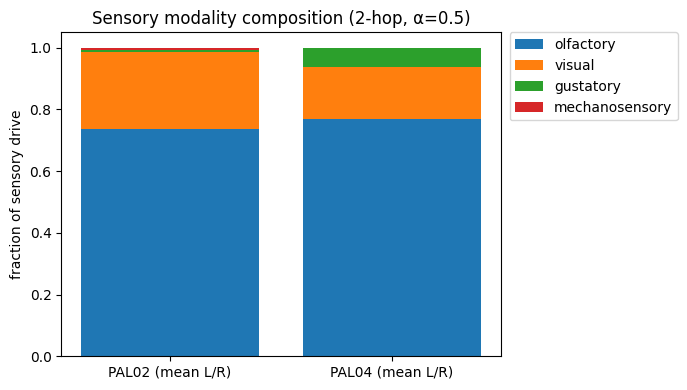

Saved stacked bar plot to: figures/modality_composition_stacked_bar.png


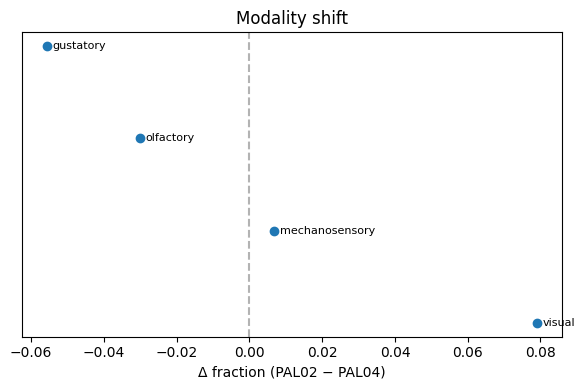

Saved Δ-fraction plot to: figures/modality_shift_delta_plot.png


In [30]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Ensure the figures directory exists
os.makedirs("figures", exist_ok=True)

order = comp.sort_values("PAL02_frac", ascending=False)["modality"].tolist()

def stacked_bar(dfL, dfR, title, min_visible=0.005, outfile="figures/modality_composition_stacked_bar.png"):
    labs = order
    L = [dfL.set_index("modality")["fraction"].get(m, 0) for m in labs]
    R = [dfR.set_index("modality")["fraction"].get(m, 0) for m in labs]

    x = np.arange(2)
    bottom = np.zeros(2)
    fig, ax = plt.subplots(figsize=(7, 4))
    visible_handles, visible_labels = [], []

    for i, m in enumerate(labs):
        vals = np.array([L[i], R[i]])
        if np.all(vals < min_visible):  # skip if tiny in both groups
            bottom += vals
            continue
        bars = ax.bar(x, vals, bottom=bottom, label=m)
        bottom += vals
        visible_handles.append(bars[0])
        visible_labels.append(m)

    ax.set_xticks(x, ["PAL02 (mean L/R)", "PAL04 (mean L/R)"])
    ax.set_ylabel("fraction of sensory drive")
    ax.set_title(title)

    if visible_labels:
        ax.legend(visible_handles, visible_labels,
                  bbox_to_anchor=(1.02, 1), borderaxespad=0.)

    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    plt.show()

    print(f"Saved stacked bar plot to: {outfile}")

    # return list of modalities that are visible
    return visible_labels


# --- Generate stacked bar and get visible modalities ---
pal02_mean = profiles["PAL02"].groupby(["label", "modality"], as_index=False)["fraction"].mean()
pal04_mean = profiles["PAL04"].groupby(["label", "modality"], as_index=False)["fraction"].mean()

visible_modalities = stacked_bar(
    pal02_mean.groupby("modality", as_index=False)["fraction"].mean(),
    pal04_mean.groupby("modality", as_index=False)["fraction"].mean(),
    "Sensory modality composition (2-hop, α=0.5)"
)

# --- Volcano-ish Δ plot (restricted to visible modalities) ---
visible_comp = comp[comp["modality"].isin(visible_modalities)].copy()
visible_comp.sort_values("delta_PAL02_minus_PAL04", ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(6, 4))
ax.axvline(0, ls='--', c='0.7')
yvals = np.arange(len(visible_comp))
ax.scatter(visible_comp["delta_PAL02_minus_PAL04"], yvals)

for i, r in enumerate(visible_comp.itertuples(index=False)):
    ax.annotate(r.modality,
                (r.delta_PAL02_minus_PAL04, i),
                xytext=(4, 0),
                textcoords="offset points",
                va="center",
                fontsize=8)

ax.set_xlabel("Δ fraction (PAL02 − PAL04)")
ax.set_yticks([])
ax.set_title("Modality shift")
plt.tight_layout()

delta_outfile = "figures/modality_shift_delta_plot.png"
plt.savefig(delta_outfile, dpi=300)
plt.show()

print(f"Saved Δ-fraction plot to: {delta_outfile}")
